<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter5/src/hyper_params_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習モデルのハイパーパラメータチューニングを行う
### 使用するデータセットの参考文献
 - Tamura, R. et al. Materials informatics approach to understand aluminum alloys. Sci Technol Adv Mater 540–551 (2020) doi:10.1080/14686996.2020.1791676

## データセットのダウンロード
 - https://www.tandfonline.com/doi/full/10.1080/14686996.2020.1791676#supplemental-material-section からtsta_a_1791676_sm7407.csvをダウンロード

### 右上の「接続」をクリックし、ランタイムに接続

## ライブラリをインストール

In [1]:
! pip uninstall -y thinc spacy fastai # 競合するライブラリを削除
! pip install optuna==3.6.1
! pip install lightgbm==4.2.0
! pip install scikit-learn==1.3.2 #ライブラリのverによっては次元圧縮の挙動が異なることがあるため注意
! pip install numpy==1.26.4
! pip install pandas==2.2.2
! pip install umap-learn==0.5.5

Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: spacy 3.8.5
Uninstalling spacy-3.8.5:
  Successfully uninstalled spacy-3.8.5
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found 

### 「ランタイム」タブから「セッションを再起動する」を選択し、「はい」をクリック

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、tsta_a_1791676_sm7407.csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [3]:
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import umap
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

## グラフ表示の際のフォントサイズを設定

In [4]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

## データを読み込み、データフレームに格納

In [5]:
data = pd.read_csv(INPUT_FILE_PATH  + "tsta_a_1791676_sm7407.csv")
data

,ID,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 5005 P,1,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,95,125,2
1,A 5005 P,1,4,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,120,145,2
2,A 5005 P,1,6,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,145,165,2
3,A 5005 P,1,8,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,165,185,2
4,A 5005 P,2,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,85,120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A 5N01 P,1,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,115,125,3
111,A 5N01 P,1,6,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,135,145,2
112,A 5N01 P,3,2,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,85,120,4
113,A 5N01 P,3,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,105,140,3


In [6]:
data = data.rename(columns={'2% proof stress (Mpa)': '2% proof stress (MPa)', 'Tensile strength (Mpa)': 'Tensile strength (MPa)'})
data

,ID,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (MPa),Tensile strength (MPa),Elongation (%)
0,A 5005 P,1,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,95,125,2
1,A 5005 P,1,4,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,120,145,2
2,A 5005 P,1,6,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,145,165,2
3,A 5005 P,1,8,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,165,185,2
4,A 5005 P,2,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,85,120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A 5N01 P,1,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,115,125,3
111,A 5N01 P,1,6,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,135,145,2
112,A 5N01 P,3,2,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,85,120,4
113,A 5N01 P,3,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,105,140,3


## ベースラインとなる回帰モデルを構築する

In [7]:
params = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42,
    "max_depth": 5,
    "n_estimators": 1000,
    "colsample_bytree": 0.7,
}

In [8]:
# 説明変数と目的変数
wt_columns = [col for col in data.columns if "(wt%)" in col]
additional_features = ["X", "n"]
all_features = wt_columns + additional_features
X = data[all_features]
y_elongation = data["Elongation (%)"]
y_proof_stress = data["2% proof stress (MPa)"]

# トレーニングとテストデータに分割
X_train, X_test, y_train_elongation, y_test_elongation = train_test_split(
    X, y_elongation, test_size=0.2, random_state=42
    )
_, _, y_train_proof_stress, y_test_proof_stress = train_test_split(
    X, y_proof_stress, test_size=0.2, random_state=42
)

# 学習データ用LightGBMモデルのトレーニング
model_elongation = lgb.LGBMRegressor(**params, verbose=-1)  # ログ出力を抑制
model_proof_stress = lgb.LGBMRegressor(**params, verbose=-1)  # ログ出力を抑制

model_elongation.fit(X_train, y_train_elongation)
model_proof_stress.fit(X_train, y_train_proof_stress)

# テストデータでの予測値
y_pred_elongation = model_elongation.predict(X_test)
y_pred_proof_stress = model_proof_stress.predict(X_test)

In [9]:
# 指標計算関数
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae


# Elongation (%) の評価指標
r2_elongation, rmse_elongation, mae_elongation = calculate_metrics(
    y_test_elongation, y_pred_elongation
)

# 2% proof stress (Mpa) の評価指標
r2_proof_stress, rmse_proof_stress, mae_proof_stress = calculate_metrics(
    y_test_proof_stress, y_pred_proof_stress
)

Text(0.5, 1.0, 'Elongation (%) - Prediction vs Actual\n')

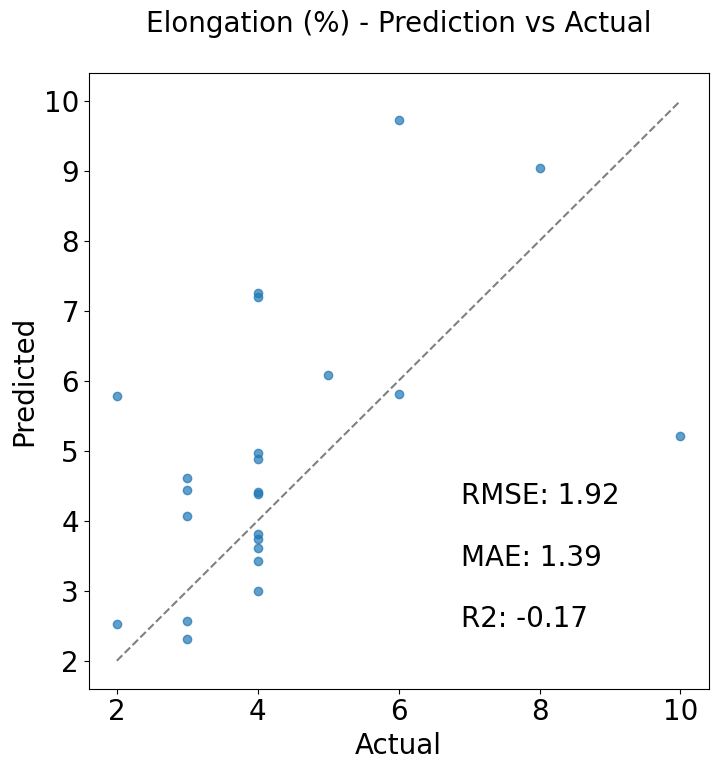

In [10]:
## Elongation (%) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_elongation, y_pred_elongation, alpha=0.7)
plt.plot(
    [y_test_elongation.min(), y_test_elongation.max()],
    [y_test_elongation.min(), y_test_elongation.max()],
    "--",
    color="gray",
    label="truth",
)
plt.text(0.6, 0.3, f"RMSE: {rmse_elongation:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE: {mae_elongation:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2: {r2_elongation:.2f}", transform=plt.gca().transAxes)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Elongation (%) - Prediction vs Actual\n")

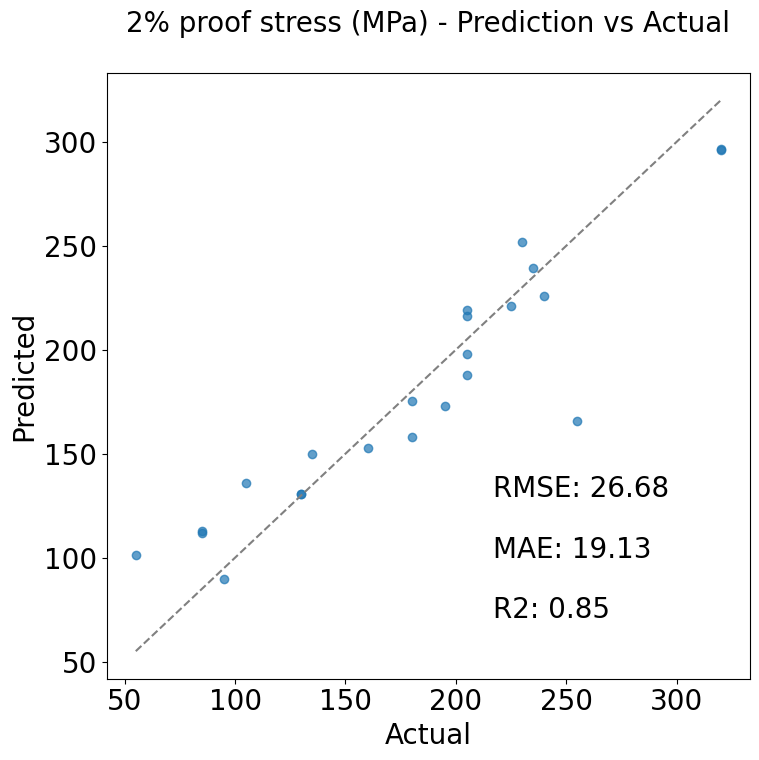

In [11]:
# 2% proof stress (Mpa) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_proof_stress, y_pred_proof_stress, alpha=0.7)
plt.plot(
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    "--",
    color="gray",
    label="truth",
)

plt.text(0.6, 0.3, f"RMSE: {rmse_proof_stress:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE: {mae_proof_stress:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2: {r2_proof_stress:.2f}", transform=plt.gca().transAxes)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"2% proof stress (MPa) - Prediction vs Actual\n")

plt.tight_layout()
plt.show()

## ハイパーパラメータチューニングを行う

In [12]:
# OptunaでElongation (%)のハイパーパラメータmin_data_in_leafをチューニング
def objective(trial):
    params = {
        "objective": "regression",
        "learning_rate": 0.01,
        "reg_alpha": 0.1,
        "reg_lambda": 0.1,
        "random_state": 42,
        "max_depth": 5,
        "n_estimators": 1000,
        "colsample_bytree": 0.7,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 30, step=5),
    }
    model = lgb.LGBMRegressor(**params, verbose=-1)  # ログ出力を抑制
    model.fit(X_train, y_train_elongation)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test_elongation, y_pred, squared=False)


sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=100)

# チューニング後のハイパーパラメータ
best_params = study.best_params
best_params

[I 2025-04-19 07:46:27,759] A new study created in memory with name: no-name-7beb508f-27d1-4b43-86c7-2319c0e95bea


{'min_data_in_leaf': 5}

## チューニングしたパラメータで回帰モデルを再構築する

In [13]:
params_opt = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42,
    "max_depth": 5,
    "n_estimators": 1000,
    "colsample_bytree": 0.7,
    "min_data_in_leaf": 5,
}

In [14]:
model_elongation_opt = lgb.LGBMRegressor(**params_opt, verbose=-1)  # ログ出力を抑制

model_elongation_opt.fit(X_train, y_train_elongation)

y_pred_elongation_opt = model_elongation_opt.predict(X_test)

r2_elongation_opt, rmse_elongation_opt, mae_elongation_opt = calculate_metrics(
    y_test_elongation, y_pred_elongation_opt
)

Text(0.5, 1.0, 'Elongation (%) - Prediction_opt vs Actual\n')

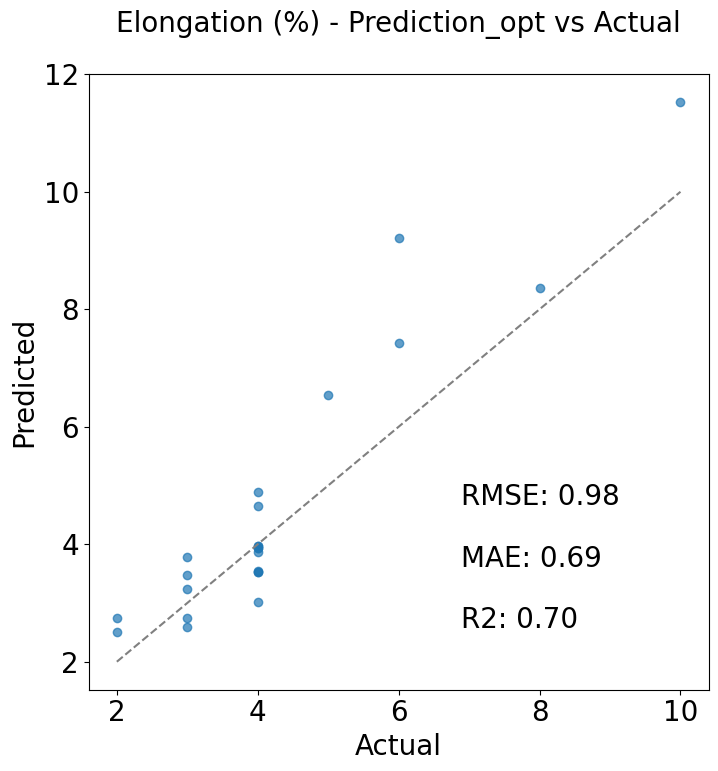

In [15]:
## Elongation (%)のハイパーパラメータmin_data_in_leafをチューニングした後のElongation (%) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_elongation, y_pred_elongation_opt, alpha=0.7)
plt.plot(
    [y_test_elongation.min(), y_test_elongation.max()],
    [y_test_elongation.min(), y_test_elongation.max()],
    "--",
    color="gray",
    label="truth",
)
plt.text(0.6, 0.3, f"RMSE: {rmse_elongation_opt:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE: {mae_elongation_opt:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2: {r2_elongation_opt:.2f}", transform=plt.gca().transAxes)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Elongation (%) - Prediction_opt vs Actual\n")

## 実行環境のライブラリverを保存

In [16]:
# Pythonのverを確認
!python3 -V

Python 3.11.12


In [17]:
!pip freeze > requirements_hyper_params_opt.txt

In [18]:
from google.colab import files

files.download('requirements_hyper_params_opt.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>